<a href="https://www.advfn.com/nasdaq/nasdaq.asp?companies=A">Nasdaq Stocks</a>

In [1]:
from datetime import datetime, timedelta
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
with open('../data/all_symbols.pkl', 'rb') as f:
    all_symbols = pickle.load(f)
    
len(all_symbols)

11032

In [3]:
def prepare_batches(all_symbols, batch_size=100):
    n = len(all_symbols)
    batches = []
    batch_start = 0
    batch_end = min(batch_start + batch_size, n)
    while batch_start < n:
        batches.append(all_symbols[batch_start:batch_end])
        batch_start = batch_end
        batch_end = min(batch_start + batch_size, n)
    return batches

In [4]:
batches = prepare_batches(all_symbols)

In [5]:
states = pd.read_csv('../data/hmm_exp_returns.csv')
states = states[['Date', 'state']]
states.index = pd.to_datetime(states.Date)
states.drop(columns='Date', inplace=True)
states.head()

,state
Date,
1970-01-02,0
1970-01-05,0
1970-01-06,0
1970-01-07,0
1970-01-08,0


In [6]:
states.state.value_counts()

3    3445
1    2025
5    1986
4    1861
0    1795
2    1212
6    1002
Name: state, dtype: int64

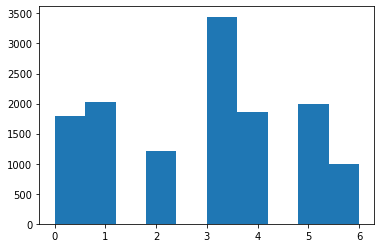

In [7]:
plt.hist(states.state);

In [8]:
STATES = sorted(states.state.unique())
STATES

[0, 1, 2, 3, 4, 5, 6]

In [9]:
CURRENT_STATE = states.state.to_numpy()[-1]
CURRENT_STATE

0

In [10]:
RUN = {
    0: 'all',
    1: 0,  # specific batch
    2: 'random_batch'
}[0]
MIN_OVERALL_SHARPE = 0.45
MIN_STOCK_PRICE = 1.00

In [11]:
if RUN == 'random_batch':
    n_batches = len(batches)
    idx = np.random.randint(0, n_batches)
    run_batches = [batches[idx]]
elif isinstance(RUN, int):
    run_batches = [batches[RUN]]
else:
    run_batches = batches
    
print('n batches:', len(run_batches))

n batches: 111


In [12]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 50
MIN_YEARS = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
min_start = TODAY - timedelta(MIN_YEARS * 365)
if min_start.weekday() == 0:
    min_start -= timedelta(2)
elif min_start.weekday() == 6:
    min_start -= timedelta(1)
START, TODAY, min_start, min_start.weekday()

(datetime.date(1972, 11, 10),
 datetime.date(2022, 10, 29),
 datetime.date(2012, 10, 31),
 2)

In [13]:
START, TODAY

(datetime.date(1972, 11, 10), datetime.date(2022, 10, 29))

In [14]:
def download_data(symbols):
    std_out = sys.stdout
    null = open(os.devnull, 'w')
    sys.stdout = null
    try:
        data = (
            yf
            .download(symbols, start=START, end=TODAY)
            .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
        data.index = pd.to_datetime(data.index)
        data = data.sort_index()
        data = data.loc[:, data.isnull().sum() != len(data)]
        missing_last = [
            col for col in list(data) if data[col].isnull()[-1]]
        data.drop(columns=missing_last, inplace=True)
        sys.stdout = std_out
        return data
    except BaseException as e:
        print(f'Failed to download data:\n{e}')

In [15]:
def adjust_min_date(min_date, dates):
    while pd.to_datetime(min_date) not in dates:
        min_date -= timedelta(1)
    return min_date

In [16]:
def filter_by_min_date(data, min_date):
    for col in data.columns:
        #if np.isnan(data.at[pd.to_datetime(min_date), col]):
        #    data.drop(columns=[col], inplace=True)
        if (
                data[col][data[col].notnull()].index[0] 
                > pd.to_datetime(min_date)):
            data.drop(columns=[col], inplace=True)
    return data

In [17]:
def filter_by_min_price(data):
    for col in data.columns:
        if (
                data[col][data[col].notnull()].to_numpy()[-1]
                < MIN_STOCK_PRICE):
            data.drop(columns=[col], inplace=True)
    return data

In [18]:
def get_daily_returns(x):
    idx = x.index
    n = len(x)
    x = np.array(x)
    returns = x[1:n] / x[0:(n-1)] - 1
    returns = pd.Series(returns, index=idx[1:])
    return returns

In [19]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [20]:
def get_sharpes_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        sharpe = get_sharpe(returns)
        stock_data.append(sharpe)
        for state in STATES:
            sharpe_state = get_sharpe(returns[data.state == state])
            stock_data.append(sharpe_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['sharpe'] + [f'sharpe_{state}' for state in STATES],
        index=stocks)
    return df_out

In [21]:
def get_annualized_daily_return(returns):
    #s_returns = returns[data.state == 0]
    returns = np.array([1] + list((returns[returns.notnull()] + 1).to_numpy()))
    amt = returns.cumprod()
    n = len(returns)
    daily_return = amt[-1]**(1/(n - 1))
    return daily_return

In [22]:
def get_daily_annualized_return_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        annualized_daily_return = get_annualized_daily_return(returns)
        stock_data.append(annualized_daily_return)
        for state in STATES:
            daily_annualized_return_state = get_annualized_daily_return(
                returns[data.state == state])
            stock_data.append(daily_annualized_return_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['dar'] + [f'dar_{state}' for state in STATES],
        index=stocks)
    return df_out

In [23]:
def best_n_by_state(df, n, state):
    candidates = df[df.sharpe >= MIN_OVERALL_SHARPE]
    return (
        candidates
        .sort_values(f'sharpe_{state}', ascending=False)
        .index[:n])

In [24]:
def process_batch(batch, min_start):
    data = download_data(batch)
    min_start = adjust_min_date(min_start, data.index)
    data = filter_by_min_date(data, min_start)
    data = filter_by_min_price(data)
    data = pd.concat([data, states], axis=1).loc[data.index, :]
    #state_sharpes = get_sharpes_by_state(data)
    #return state_sharpes
    state_dars = get_daily_annualized_return_by_state(data)
    return state_dars

In [25]:
dfs = []
print('Beginning batch:')
for batch in batches:
    print(batch[0], end=' ')
    df = process_batch(batch, min_start)
    dfs.append(df)

Beginning batch:
A ACER ADXS AHAC ALJJ AMOT APEN ARII ASVI AVCO BAH BDJ BIE BLTI BR BTI CACQ CBNK CDTX CGFW CIT CLWT CNVX CPLG CSBR CUBI CYPB DEA DLGC DRIO DXCM EE 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_51167/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


EMBC EPM ETR EZGO FE FIV FNVT FSLA FXJP GENI GLBC GOAM GSM HBCP HGLB HOG HTRN ICAB IGU INHO IPVI 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_51167/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


IVR JMSB KERX KRMD LCA LIN LPI LYV MCD MERX MIR MNTK MS MUE NAV NETI NM NRDS NURO 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_51167/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


NYXH OLLI ORCL PACX PCX PGHD PLL POWW PSAG PXMD RADI RENT RLTY RRI SAGA SCLN 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_51167/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


SFLY SILV SMMC SOLO SRCH STJ SWBD TBBK TFC TLEO TPPP TSHA TYDE UNFI VAC VINT VQS VYNE WGO WRE XENE YDKN ZOM 

In [43]:
df = pd.concat(dfs, axis=0)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6
A,1.000284,0.995305,1.000880,1.000413,1.001212,1.001900,1.001871,1.015513
AA,1.000260,0.994096,1.000864,1.000902,1.001341,1.001281,1.001140,1.000955
AAIC,0.999497,0.992777,1.001123,1.000107,1.001658,1.000876,0.999995,1.017785
AAL,0.999939,0.993437,0.999617,1.002933,1.000821,1.000282,1.002048,1.021618
AAME,0.999985,0.996303,1.000140,1.001082,1.000616,1.001182,0.999939,1.001375


In [27]:
df.tail()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6
ZTEK,1.000550,0.998138,0.998134,0.999655,1.006339,1.001396,0.998759,1.038174
ZTR,1.000190,0.998299,1.000174,1.000275,1.000664,1.000640,1.000706,1.001146
ZUMZ,1.000136,0.995323,0.999927,1.001651,1.000244,1.001171,1.001824,1.003438
ZWS,1.000051,0.992694,1.001184,0.997106,1.001189,1.001867,1.001610,1.019815
ZYXI,1.000448,0.997742,1.001480,1.001063,1.000368,0.997951,1.002796,1.020438


In [28]:
df.to_csv('../data/sharpes_by_state.csv', index=True)

In [29]:
df = pd.read_csv('../data/sharpes_by_state.csv', index_col=0)

In [30]:
CURRENT_STATE# = 0

0

In [31]:
# Weighted Best
# 3: 0.2, 0.6, 0.2
# 2: 0.6, 0.4
#df['weighted'] = {
#    0: 0.6*df.sharpe_0 + 0.4*df.sharpe_1,
#    1: 0.2*df.sharpe_0 + 0.6*df.sharpe_1 + 0.2 * df.sharpe_2
#}[CURRENT_STATE]

df['weighted'] = {
    0: (0.7*df[f'dar_{CURRENT_STATE}'] 
        + 0.1*df[f'dar_{CURRENT_STATE + 1}']
        + 0.2*df.dar),
    #1: (0.6*df[f'dar_{CURRENT_STATE}']
    #    + 0.1*df[f'dar_{CURRENT_STATE + 1}']
    #    + 0.1*df[f'dar_{CURRENT_STATE - 1}']
    #    + 0.2*df.dar)
}[CURRENT_STATE]

df = df.sort_values('weighted', ascending=False)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,weighted
ELC,1.001289,1.006961,1.000757,0.996780,1.000468,1.001713,1.001058,0.989022,1.005206
BTTR,0.996148,1.006935,0.990837,0.991819,0.987436,1.007892,0.993256,0.988890,1.003168
AMEH,1.000384,1.004633,0.993703,1.004667,1.003551,0.995914,1.001712,1.021977,1.002691
SOBR,1.000038,1.003181,1.002307,0.996586,1.001565,1.000139,0.995591,1.106454,1.002465
MICS,0.999250,1.002053,1.001545,0.996034,0.997985,0.998794,0.996990,0.995634,1.001442


In [32]:
df.mean(), df.median()

(dar         1.000164
 dar_0       0.996336
 dar_1       1.000344
 dar_2       1.000653
 dar_3       1.000978
 dar_4       1.001116
 dar_5       1.000940
 dar_6       1.008762
 weighted    0.997502
 dtype: float64,
 dar         1.000258
 dar_0       0.996494
 dar_1       1.000430
 dar_2       1.000679
 dar_3       1.000993
 dar_4       1.001107
 dar_5       1.000934
 dar_6       1.007145
 weighted    0.997655
 dtype: float64)

In [33]:
exclude = {
    0: [
        'ABST', 'AGI', 'AMEH', 'APT', 'BGS', 'CZFS', 'DTST', 'ELC', 'ESOA',
        'FNV', 'FSI', 'GCBC', 'GME', 'IDR', 'MUJ', 'MTA', 'NPV', 'OLB', 'SVFD', 'WTRG'
    ],
    1: [
        'CVE', 'DTST', 'ELC', 'FSI', 'MOBQ']}

In [34]:
best_weighted = [
    s for s in df.index if s not in exclude[CURRENT_STATE]
][:20]
#sorted(best_weighted)

In [35]:
print(sorted(best_weighted))

['BTTR', 'BYRN', 'CEF', 'CGAU', 'CIZN', 'DYAI', 'HMY', 'HNRG', 'IEI', 'MGF', 'MICS', 'MMU', 'MUE', 'NAN', 'NOM', 'NXN', 'NXP', 'OMQS', 'RVP', 'SOBR']


In [36]:
df.loc[best_weighted]

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,weighted
BTTR,0.996148,1.006935,0.990837,0.991819,0.987436,1.007892,0.993256,0.988890,1.003168
SOBR,1.000038,1.003181,1.002307,0.996586,1.001565,1.000139,0.995591,1.106454,1.002465
MICS,0.999250,1.002053,1.001545,0.996034,0.997985,0.998794,0.996990,0.995634,1.001442
BYRN,1.000205,1.002302,0.995580,1.000080,1.000439,1.001062,1.002725,1.000446,1.001210
OMQS,0.999857,1.001377,1.000616,1.004095,0.993961,1.002084,0.999106,1.004392,1.000997
HNRG,1.000195,1.001201,0.998844,1.002700,1.001200,0.999458,0.999764,1.008693,1.000764
HMY,0.999960,1.000637,1.000457,0.999231,0.999048,0.999217,1.000184,1.005885,1.000483
CGAU,0.999981,1.000548,1.000368,0.999131,1.000417,1.000204,0.999272,0.991952,1.000417
DYAI,1.000286,1.000771,0.998170,1.000227,1.000510,1.002092,1.000413,1.003802,1.000414
CEF,1.000129,1.000382,1.000197,0.999863,1.000250,0.999811,1.000187,0.999703,1.000313


In [37]:
data = (
    yf
    .download(best_weighted, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']

[*********************100%***********************]  20 of 20 completed


In [38]:
data.index = pd.to_datetime(data.index)
data = data.sort_index()
data.tail()

,BTTR,BYRN,CEF,CGAU,CIZN,DYAI,HMY,HNRG,IEI,MGF,MICS,MMU,MUE,NAN,NOM,NXN,NXP,OMQS,RVP,SOBR
Date,,,,,,,,,,,,,,,,,,,,
2022-10-24,0.96,7.15,15.70,4.61,14.4100,2.00,2.72,6.97,112.809998,3.12,5.3600,9.42,9.52,9.720,11.86,10.86,13.05,5.930,2.45,3.90
2022-10-25,1.03,7.37,15.82,4.73,14.6000,2.08,2.76,7.17,113.419998,3.16,5.8000,9.51,9.53,9.720,11.86,11.24,13.08,5.949,2.45,3.91
2022-10-26,1.07,7.36,15.94,4.78,15.0300,2.15,2.86,7.30,113.690002,3.20,5.5800,9.56,9.62,9.720,11.42,11.17,13.10,5.930,2.41,3.87
2022-10-27,1.07,6.96,15.81,4.73,15.0000,2.21,2.86,7.39,114.290001,3.25,5.4100,9.50,9.44,9.710,12.04,11.13,12.98,6.180,2.37,3.98
2022-10-28,1.03,6.90,15.58,4.74,14.6001,2.32,2.86,7.45,113.820000,3.26,5.5388,9.47,9.49,9.745,11.57,11.21,13.14,5.990,2.42,3.31


In [39]:
data = pd.concat([data, states], axis=1)

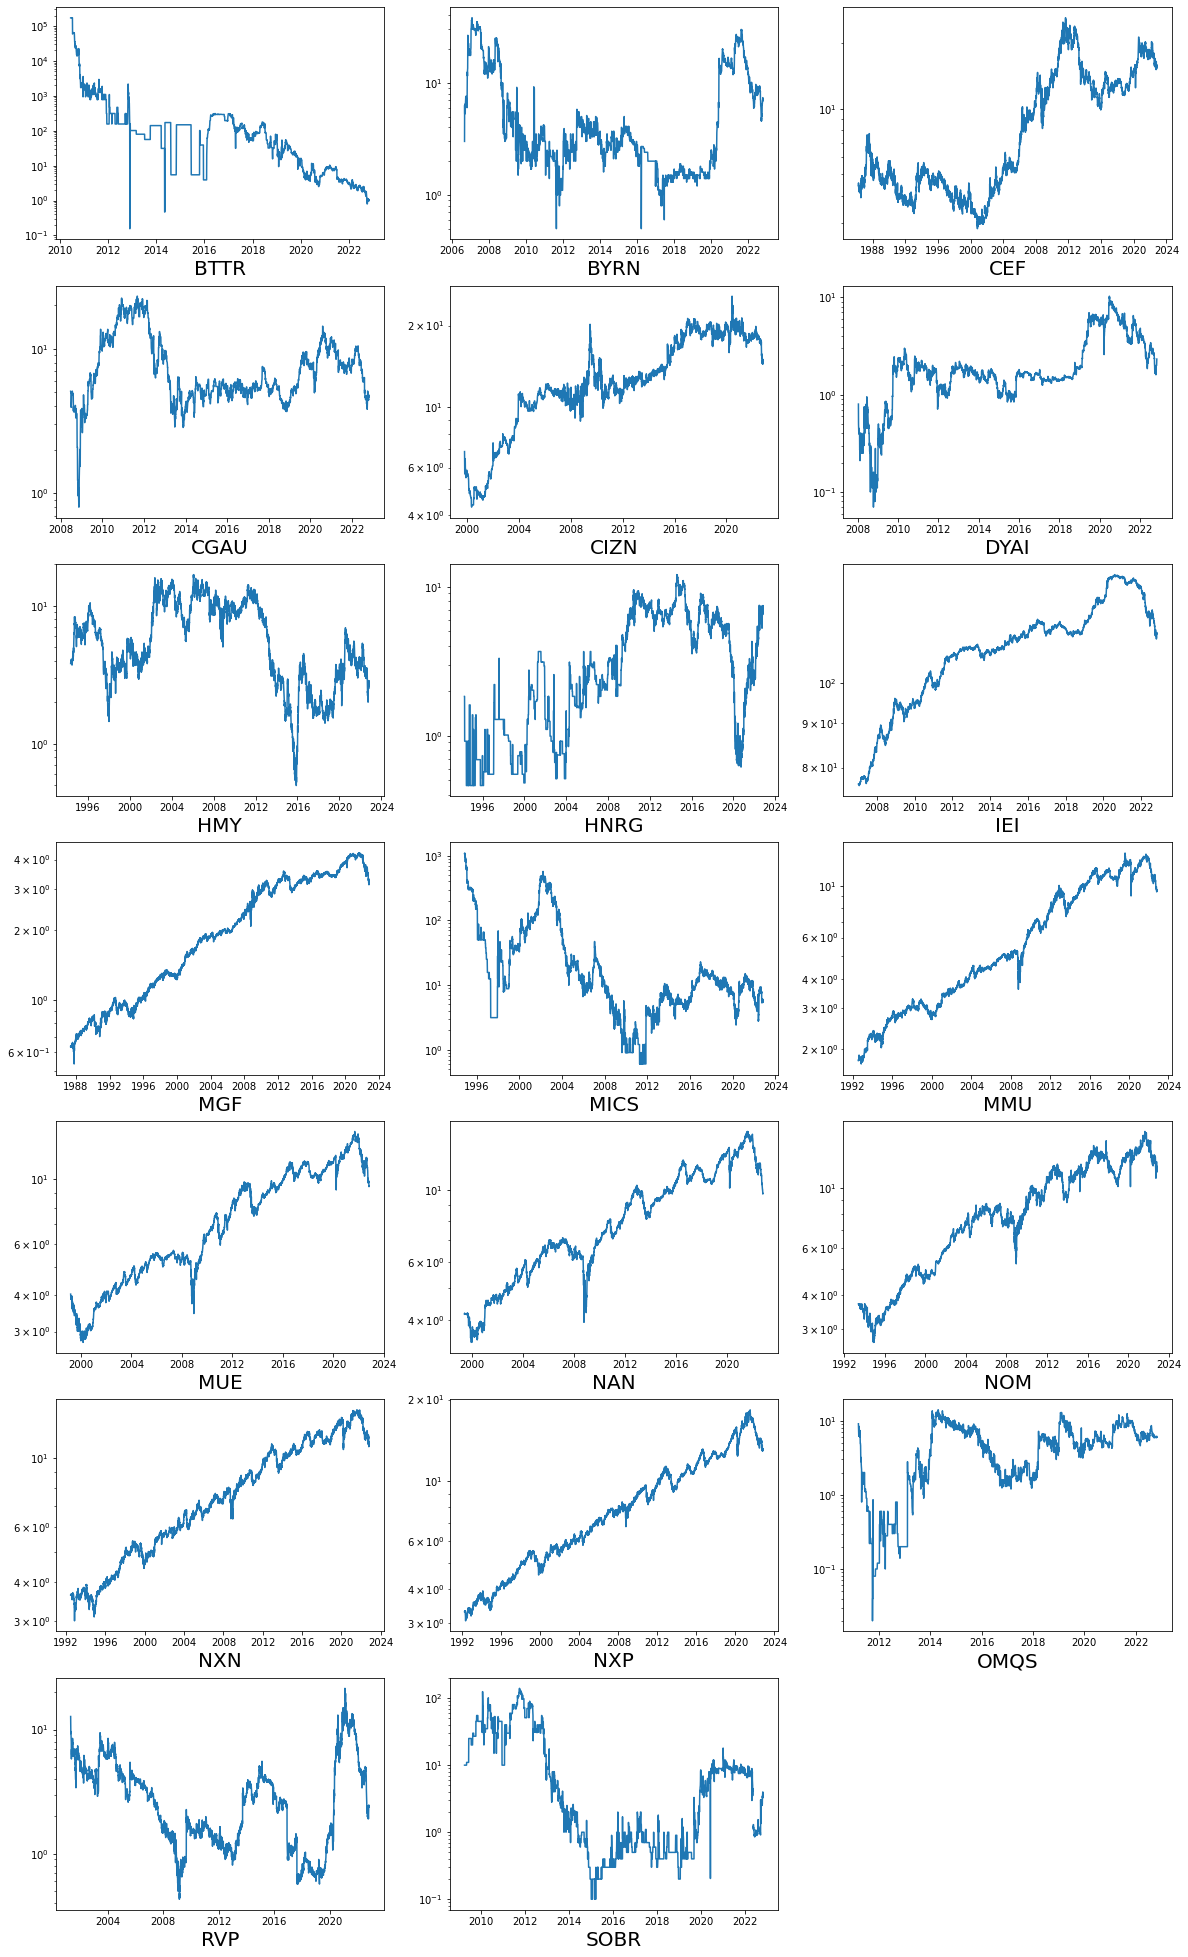

In [40]:
plt.rc('axes', labelsize=20)
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    plt.plot(data[sym])
    plt.xlabel(sym)
    plt.yscale('log');

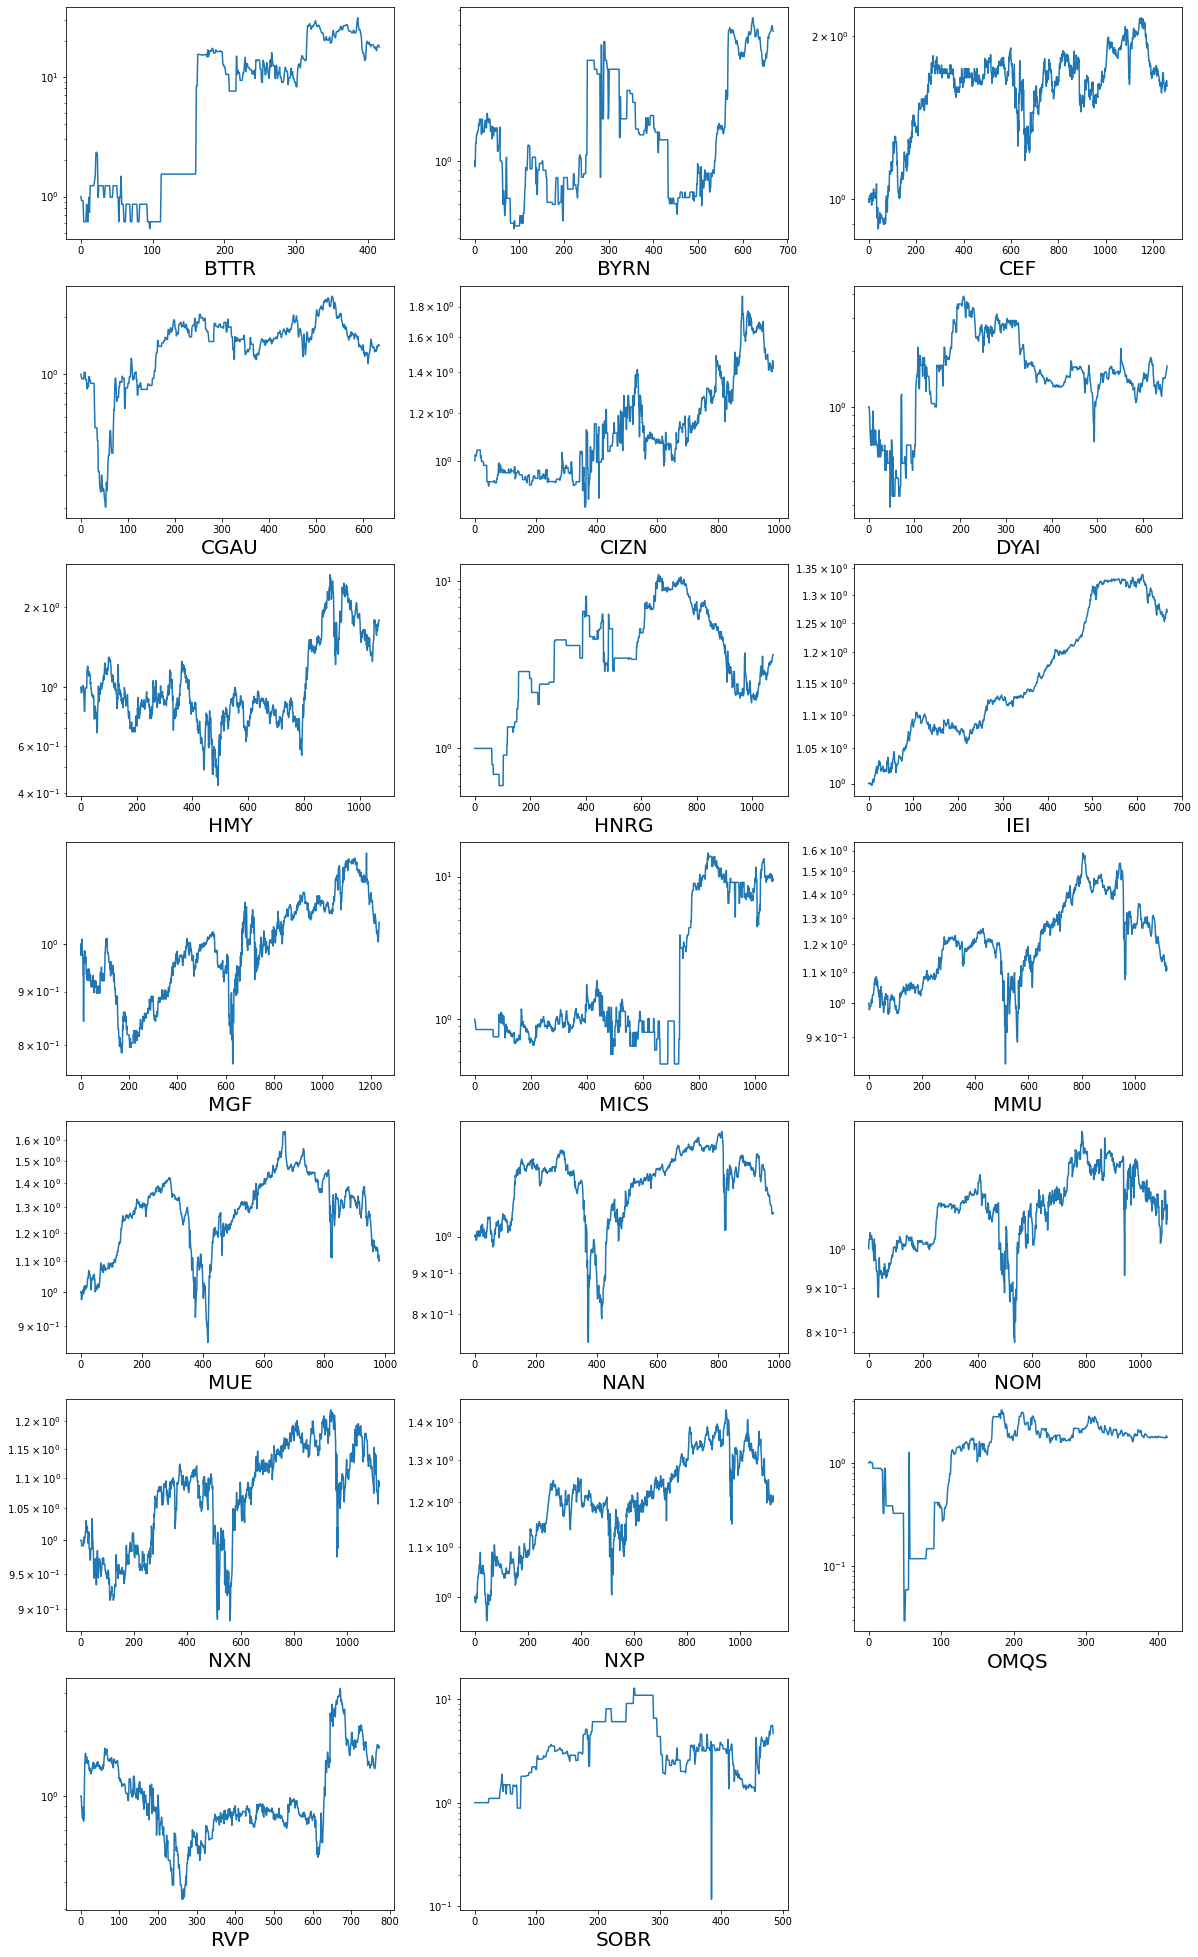

In [41]:
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    dr = get_daily_returns(data[sym])
    dr = dr[data.state == CURRENT_STATE]
    dr = dr[dr.notnull()]
    dr = (dr + 1).to_numpy()
    dr = np.array([1] + list(dr))
    plt.plot(dr.cumprod())
    plt.yscale('log')
    plt.xlabel(sym);

In [42]:
#for stock in df_out.index:
#    if stock in big_df.index:
#        big_df.loc[stock, :] = big_df.loc[stock, :]
#    else:
#        big_df = pd.concat(
#            [big_df, pd.DataFrame(df_out.loc[stock, :]).T], axis=0)
#print(big_df.shape)
#big_df.head()